# Summary: Single Layer Neural Networks from a Statistical Perspective
(based on "Introduction to statistical learning")

## Conceptual Overview
**Purpose**: A neural network aims to build a nonlinear function `f(X)` to predict the response `Y`, using an input vector of variables `X = (X1, X2, ..., Xp)`. Unlike trees, boosting, and generalized additive models, neural networks have a unique structure characterized by *layers* and *neurons*.

# The MNIST dataset

According to Wikipedia:

"The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.(...) The black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.[7]

The MNIST database contains 60,000 training images and 10,000 testing images."

Instead of using the full MNIST database, we are going to work with mini-mnist-1000 (link: https://github.com/yasserius/mini-mnist-1000), which is "a small subset of 1000 images from MNIST, 100 images for each digits."

Given that each image is 2 dimensional, and a neural network input observation must be 1 dimensional, we are going to "flatten" (map) each image to a flat $width * height$ dimensional vector.

We are also going to split the dataset on a training and test groups on a 80/20 proportion.



*This section is based on the paper "The Neural Network, its Techniques and Applications" by Casey Schafer (2016)*

# Basic Neural Network: Perceptron

A **perceptron** is the most basic form of a neural network. It consists of one layer of inputs (independent variables or features) and one layer of outputs (dependent variables). Let's break down the components and the operation of this network step by step, exemplifying with :

## Layers and Vectors

1. **Layers**: In a perceptron, layers are visualized as a series of neurons or nodes (each node corresponding to a variable) aligned vertically. With n features and k observations, a layer is represented as a matrix `n × k` .

2. **Input Layer (X)**: For example, a perceptron with 2 features and `k` observations, the input layer is a `2 × k` matrix (matrix `X`). We are going to model the "mini MNIST" data, which will have (28 x 28) input features and 800 training observations, so the input layer matrix has a 784 x 800 shape.

3. **Output Layer (Y)**: On the other hand, an output layer (matrix `Y`) is typically `n × p` ("p" being the number of output features), in this case we will model each possible digit (0 to 9) as a binary variable, so it will have 10 x 800 shape. `Y` will be our prediction matrix and `T`  our label matrix.

## Goal of the Neural Network:
The objective is to minimize the difference between the known output `T` and the predicted output `Y`.

## Weight Matrix (W)

To map from `X` to `Y`, we introduce a weight matrix `W`. In general, `W` is an `n × m` matrix, where `m` is the number of input nodes, independent of the number of observations. In this case we have 784 input features and 10 output features, so it has a 10 x 784 shape. The fundamental equation of the network is: `T = W * X + b`, where `b` is a bias vector.

## Linearization

For simplicity, we are going to linearize this equation. To linearize this equation, augment (append as a last column) `W` with `b` as `[W | b]` and add a row of 1’s at the end of matrix `X`, which will be the matrix equivalent of $W*X + b$. The equation becomes: `T = [W | b] * [X; 1]` or $T=WX$ (which means we can solve this using a simple linear transformation). We must redefine the shape of matrix `W` to be `n × (m + 1)` and also change the shape of matrix `X` to be `(m + 1) × p` with a row of 1’s at the bottom.

## Solving for W

If this was a single row, we could just simply divide $T/X$ to solve for W. Instead, we must compute the pseudoinverse of `X` using singular value decomposition (SVD) to find an approximation of `W`, denoted as `Ŵ`. We use the "pseudoinverse" instead of the "inverse" of a matrix ($A^-1$) because the pseudoinverse can be used in non-square and in non-invertible matrixes (which is incidentally our case for the MNIST dataset)
We remember from one of our beloved past notebooks in CSE-6040 that any matrix A can be expressed as $A = U \Sigma V^T$ using SVD. Now the approximation `Ŵ` is calculated as `Ŵ = T * V * Σ⁻¹ * Uᵀ`, where `V`, `Σ`, and `U` are derived from the SVD of `X`. 

## Setup

We must install the required libraries and load the dataset.

In [47]:
%pip install scikit-learn numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


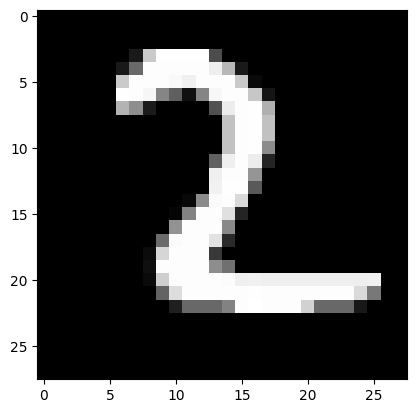

This image is a 2 digit


In [48]:
import numpy as np
import pickle

np.random.seed(42) # for reproducibility

with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images'] # a list of 1000 numpy image matrices
labels = data['labels'] # a list of 1000 integer labels

# Lets visualize an image

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(images[234], cmap='gray')
plt.show()

print("This image is a", labels[234], "digit")


## Flattening the images

Given we are working with a simple perceptron, we must flatten each image into a vector of length 784. After we have done that, we can create a single matrix of all the images, where each row is an image vector.

In [49]:
# Lets flatten the images into vectors
print("Original image shape:", images[0].shape)  # (28, 28)

print("Flattened image shape: ", images[0].flatten().shape) # numpy.flatten() flattens a matrix into a vector, handy!

X = np.array([image.flatten() for image in images])
X = X.T  # transpose so that X is an input matrix of "features x observations" shape as defined earlier
print("X shape:", X.shape)  # (784,1000)

Original image shape: (28, 28)
Flattened image shape:  (784,)
X shape: (784, 1000)


## Converting the target variable using one-hot encoding

We also need to convert the labels so that they are one-hot encoded.
Given that each label is an integer between 0 and 9, we can create a 10-dimensional vector for each label row.
The vector will have a 1 in the position of the digit label and 0s everywhere else (a very *sparse* matrix).

In [50]:
T = np.zeros((len(labels), 10))
for i, label in enumerate(labels):
    T[i, label] = 1 # one-hot encoding works by setting the index of the correct class to 1
T = T.T  # transpose T so that it is a matrix of "digit classes x observations" shape as defined earlier
print("T shape:", T.shape)  # (10,1000)
print(T)

T shape: (10, 1000)
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


## Train/test split

Before we start coding, let's make sure we separate our dataset into training and test

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, T_train, T_test = train_test_split(
    X.T, T.T, test_size=0.2, random_state=42
)

X_train = X_train.T
X_test = X_test.T
T_train = T_train.T
T_test = T_test.T

print("X_train shape:", X_train.shape)  # (784,800)
print("X_test shape:", X_test.shape)  # (784,200)
print("T_train shape:", T_train.shape)  # (10,800)
print("T_test shape:", T_test.shape)  # (10,200)

X_train shape: (784, 800)
X_test shape: (784, 200)
T_train shape: (10, 800)
T_test shape: (10, 200)


## Coding our first implementation

We are now ready to start coding our simple perceptron implementation. For this very simple algorithm, we won't even need to intialize W and b , because we are estimating W directly from just the labels and X matrix (T_train and X_train, respectively)

In [52]:
def compute_pseudoinverse(X):
    """
    Computes the pseudoinverse of matrix X.
    """
    X_pinv = np.linalg.pinv(X)  # For simplicity let's just use numpy's pseudoinverse function
    return X_pinv


def train_perceptron(X, T):
    """
    Trains the perceptron using pseudoinverse to find the optimal weights.
    """
    X_pinv = compute_pseudoinverse(X)
    W_hat = np.dot(T, X_pinv)
    return W_hat


def predict(X, W):
    """
    Uses the trained perceptron to predict outputs.
    """
    return np.dot(W, X)


print("X train shape:", X_train.shape)
print("T train shape:", T_train.shape)
print("X:", X_train)
print("T:", T_train)

# Augmenting X with a row of 1's
X_train_perceptron = np.vstack((X_train, np.ones(X_train.shape[1]))) # numpy.vstack() stacks arrays in sequence vertically (row wise)
print("New X_train_perceptron shape:", X_train_perceptron.shape)



# Training the perceptron
W_hat_perceptron = train_perceptron(X_train_perceptron, T_train)
print("W_hat_perceptron shape:", W_hat_perceptron.shape)
print("W_hat_perceptron:", W_hat_perceptron)

# Predicting new inputs
X_test_perceptron = np.vstack((X_test, np.ones(X_test.shape[1])))

print("New X shape:", X_test_perceptron.shape)
print("New X:", X_test_perceptron)


predictions = predict(X_test_perceptron, W_hat_perceptron)

print("Predictions:", predictions)

X train shape: (784, 800)
T train shape: (10, 800)
X: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
T: [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
New X_train_perceptron shape: (785, 800)


W_hat_perceptron shape: (10, 785)
W_hat_perceptron: [[ 0.00000000e+00 -6.97629963e-13 -2.84246769e-11 ...  0.00000000e+00
   0.00000000e+00  1.56674813e-01]
 [ 0.00000000e+00 -1.25290585e-11  8.76701572e-11 ...  0.00000000e+00
   0.00000000e+00  2.50959923e-01]
 [ 0.00000000e+00 -3.30807810e-12  8.00058012e-11 ...  0.00000000e+00
   0.00000000e+00  6.95264908e-02]
 ...
 [ 0.00000000e+00 -1.57136467e-11  8.13014497e-11 ...  0.00000000e+00
   0.00000000e+00  1.66003841e-01]
 [ 0.00000000e+00 -9.82717487e-12 -5.47844398e-11 ...  0.00000000e+00
   0.00000000e+00 -2.27243223e-01]
 [ 0.00000000e+00  2.34344534e-11 -1.13801034e-10 ...  0.00000000e+00
   0.00000000e+00  2.14656533e-01]]
New X shape: (785, 200)
New X: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]]
Predictions: [[-0.10138945 -0.22739021 -0.79845901 ... -0.48454433  0.33004696
   0.53625766]
 [-1.77468293  1.023938    1.87

Let's see the perceptron model performance

In [53]:
# We can now calculate the prediction performance using sklearn performance metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# We need to convert the predictions from a matrix to a vector of labels.
# We can do this by taking the index of the maximum value in each column.

y_pred_perceptron = np.argmax(predictions, axis=0)
print("Predictions shape:", predictions.shape)
print("y_pred shape:", y_pred_perceptron.shape)
print("y_pred:", y_pred_perceptron)

# Now we can calculate the performance metrics.

y_true = np.argmax(T_test, axis=0)
print("y_true shape:", y_true.shape)
print("y_true:", y_true)

print("Accuracy:", accuracy_score(y_true, y_pred_perceptron))
print("Precision:", precision_score(y_true, y_pred_perceptron, average="macro"))
print("Recall:", recall_score(y_true, y_pred_perceptron, average="macro"))
print("F1 score:", f1_score(y_true, y_pred_perceptron, average="macro"))

Predictions shape: (10, 200)
y_pred shape: (200,)
y_pred: [8 1 1 8 4 0 0 5 3 1 8 0 6 9 9 8 2 5 7 7 8 1 3 5 8 3 1 1 9 6 3 1 6 4 7 1 6
 5 4 0 5 0 3 9 9 9 9 1 4 9 3 8 2 5 5 0 6 0 9 8 8 0 5 2 6 6 6 8 9 5 1 9 5 7
 3 4 6 0 5 5 8 0 7 0 3 1 1 4 1 4 8 4 5 1 7 4 4 0 0 5 5 1 4 8 6 6 1 9 1 9 1
 8 9 8 5 4 1 9 1 5 0 4 9 1 9 5 6 4 8 8 8 5 2 9 0 0 1 1 0 9 0 8 1 4 8 9 3 5
 6 0 4 1 5 4 9 8 4 6 0 8 4 1 6 3 8 0 2 6 3 3 3 9 1 9 4 3 2 9 8 6 4 5 3 4 8
 1 3 3 9 7 9 8 6 1 2 4 3 7 6 0]
y_true shape: (200,)
y_true: [5 7 7 6 4 6 6 5 8 1 8 0 6 9 9 8 2 8 7 3 5 1 3 5 2 2 1 9 9 9 3 1 6 4 3 1 6
 5 9 0 3 0 3 9 2 2 9 6 4 8 5 8 2 5 0 0 6 0 2 8 2 0 5 2 6 6 6 8 0 5 1 4 5 7
 2 2 6 0 5 3 6 0 2 0 3 5 9 7 7 3 3 4 5 2 7 4 7 0 0 8 7 3 9 2 6 6 5 9 1 9 5
 8 9 8 0 4 1 9 5 2 8 4 7 2 2 5 5 4 8 8 5 8 2 9 5 0 1 2 0 0 0 2 7 2 8 9 8 2
 8 3 6 1 9 4 9 4 3 6 0 8 5 7 6 6 8 6 2 6 3 3 3 4 1 9 4 3 2 2 8 6 4 6 3 5 8
 1 3 3 9 7 9 8 6 1 2 4 3 2 6 0]
Accuracy: 0.6
Precision: 0.6314451257992644
Recall: 0.6199385220254785
F1 score: 0.5852993982657942

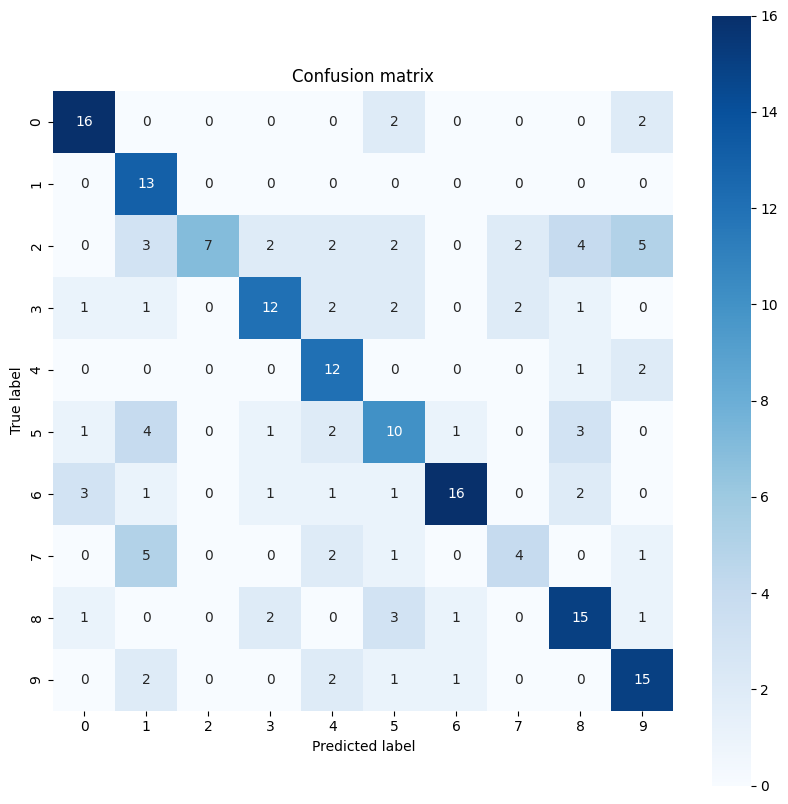

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_perceptron)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', square=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

Wow! Amazing performance from this little perceptron guy! Let's move on to the theory again to introduce a new concept: "hidden" layers.

# Introducing Hidden Layers

We want to be able to model more complex relationships. We could assume that the relationship between the flattened matrix of an image and the digit represented in that image is *not* linear, and instead implies a complex relationship (although this is surprisingly controversial: https://stats.stackexchange.com/questions/426873/how-does-a-simple-logistic-regression-model-achieve-a-92-classification-accurac). To model that increased complexity we can use what is called a "hidden layer".

## Enhanced Structure

In between the input and the output layers, we will add a middle layer. This means that instead of going directly from a 784 dimensional space to a 10 dimensional one, we will go from 784 dimensions, to S dimensions, and from S dimensions to 10 dimensions. Our middle (hidden) layer then is an S dimensional space. For our case we will use 128 dimensions for our hidden layer.

## Weight Matrix and Adaptive Learning

Now for estimating our weight matrix W, we won't estimate it directly from X. Instead we are going to iterate over itself and so we will optimize W in a way. The first version of W will be initialized randomly, and over each iteration we will be *nudging* it, instead of starting from scratch each time.

## Transformation in the Hidden Layer
Let's define "P" as `P = W X`, so kind of how we defined "T" for our perceptron. This will model the hidden layer, but we are now going to add a bit more complexity. We will apply a component-wise function "sigma" to `P` to get `S`, so $P=WX$ and $S = sigma(P)$ 

We will call this "sigma" function an "activation function". This will helps us to model complex non-linear relationships and interaction effects. We will use the sigmoid activation function, which given an input "z" is defined as:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}

$$
After applying sigma, its output will become the input for the next layer, which in our case will be just the output layer.
$$ S = sigma(WX) $$

We could also apply another activation function to the output layer, but for simplicity won't. 


## Output Matrix and Error Calculation

Finally, our output matrix could be defined as our perceptron last time:
$$
Y = WX
$$

But now the input matrix X is actually the output of the hidden layer, and given that both layers have different weight matrixes let's add a subscript to each to differentiate them ("o" for output and "h" for hidden), so:

$$
Y = W_o * sigma(W_h * X)
$$


Like last time, we will try to make the predicted labels to be as close as posible to the real labels. We will now introduce an error function, that will be defined as:

$$E(W_h, W_o) = \sum (t_k - y_k)^2$$

Where t is a label and y a prediction.

## Error optimization via Gradient Descent

Our final piece of the puzzle is a way to minimize the error function we just introduced. For that, we are going to use something called "Gradient descent". After each iteration of updating W, we evaluate our error function and we ask "where do we go from here to minimize our error?". For that, we calculate the gradient of the error function at that specific point, which will give us a set of vectors (each one corresponding to a dimension of our hidden layer) that point us in the direction of the greatest change (actually in the direction of the function greatest *increase*, so we must take the exact **opposite** direction!). 

We will take advantage of numpy using its *gradient* method, which according to numpy's documentation outputs "*A list of ndarrays (or a single ndarray if there is only one dimension) corresponding to the derivatives of f with respect to each dimension. Each derivative has the same shape as f.*" (in our case f is the error function). 

## Learning rate parameter

Like we mentioned before, we want to make *small nudges* to our W matrix each iteration, so we will scale that set of vectors by $\alpha$, a scalar we will call a "learning rate". This learning rate is a parameter we define, and basically will affect the size of the "step" we take towards the error minimization. If we take big steps, we risk not finding a global optima, and if we take small steps we risk taking a long time to find the optima. 



## Backpropagation

*Shoutout to https://www.3blue1brown.com/lessons/backpropagation-calculus for an excelent summary on backpropagation calculus*

We now have all the elements to try to minimize our error function. 

Remember that all we can modify are the W matrixes ($W_h,W_o$ for the weight matrix of our hidden and output layers respectively)

Given the error function:
$$ E(t, y) = \sum  (t - y)^2  $$

Where:
- $ t $ is the true output.
- $ y $ is the predicted output.

We want to find out the impact of a very small change in each element of the W matrixes on the computed error at a specific evaluation point. That is why we calculate the gradient of the error function with respect to the weights as follows:

1. **Output Layer (Layer o)**: 
    - Using the *chain rule* we start from the "end", so the output layer first
    
    - The gradient for weights in the output layer is:
      $$
      \frac{\partial E}{\partial W^{[o]}} = \frac{\partial E}{\partial y} \cdot \frac{\partial y}{\partial z^{[o]}} \cdot \frac{\partial z^{[o]}}{\partial W^{[o]}}
      $$
      where $ \frac{\partial y}{\partial z^{[o]}} $ is the derivative of the sigmoid function and $ \frac{\partial z^{[o]}}{\partial W^{[o]}} $ is the activation from the hidden layer.
    - The derivative of the error function with respect to the output is 
    $$ \frac{\partial E}{\partial y} = 2 \times (y - t) $$

2. **Hidden Layer (Layer h)**:
    - The derivative of the error function with respect to the activations of the hidden layer is computed by backpropagating the error from the output layer.
    - The gradient for weights in the hidden layer is:
      $$
      \frac{\partial E}{\partial W^{[h]}} = \left( \frac{\partial E}{\partial z^{[o]}} \cdot W^{[o]} \right) \cdot \frac{\partial z^{[o]}}{\partial a^{[h]}} \cdot \frac{\partial a^{[h]}}{\partial z^{[h]}} \cdot \frac{\partial z^{[h]}}{\partial W^{[h]}}
      $$

In these equations:
- $ \frac{\partial a^{[l]}}{\partial z^{[l]}} $ is the derivative of the sigmoid function at layer $ l $.
- $ \frac{\partial z^{[l]}}{\partial W^{[l]}} $ is the activation from the previous layer (or input for the first layer).


# Coding our final implementation

We now have to implement the following:
- Code our activation function (sigmoid)
- Initialize W and b for the hidden and output layers, so we will set them to some random (small) value. 
- Set our $\alpha$ parameter
- Code our gradient function 
- Evaluate the error function for a specific point

And most important of all, we must put everything together in our optimization function, which will:
1. Take as input the current W matrixes ($W_o,W_h$), X_train, T_train, alpha, and desired number of iterations
2. For each iteration:
    1. Evaluate error function
    2. Calculate gradient at evaluation point
    3. Update W based on alpha x gradient
3. Output final W matrixes ($W_o,W_h$)

In [95]:



def sigmoid(signal):
    # Prevent overflow.
    signal = np.clip( signal, -500, 500 )
    
    # Calculate activation signal
    signal = 1.0/( 1 + np.exp( -signal ))
    
    return signal


def initialize_parameters(X, y):
    """
    Initializes the weights and biases
    "h" sufix indicates hidden layer, and "o" output layer
    The output differentiates W and b for each layer
    """

    n_x = X.shape[0]  # number of input layer features
    n_h = 128  # number of hidden layer features
    n_y = y.shape[0]  # number of output layer features

    W_h = np.random.randn(n_h, n_x) * 0.01  # initial random weights for hidden layer
    b_h = np.zeros((n_h, 1))  # initial zero bias for hidden layer

    W_o = np.random.randn(n_y, n_h) * 0.01  # weights for output layer
    b_o = np.zeros((n_y, 1))  # bias for output layer

    return W_h, b_h, W_o, b_o


W_h, b_h, W_o, b_o = initialize_parameters(X_train, T_train)
print("W_h shape:", W_h.shape)
print("W_h sample: ", W_h[0:3, 0:3])
print("b_h shape:", b_h.shape)
print("b_h sample: ", b_h[0:3, 0:3])
print("W_o shape:", W_o.shape)
print("W_o sample: ", W_o[0:3, 0:3])
print("b_o shape:", b_o.shape)
print("b_o sample: ", b_o[0:3, 0:3])

W_h shape: (128, 784)
W_h sample:  [[ 0.00945899  0.00419502  0.00692083]
 [ 0.0006826   0.01060961  0.01937979]
 [ 0.0140712  -0.00140176 -0.00751783]]
b_h shape: (128, 1)
b_h sample:  [[0.]
 [0.]
 [0.]]
W_o shape: (10, 128)
W_o sample:  [[ 0.00784008  0.00326401  0.0074738 ]
 [-0.0019498   0.01884036  0.00396145]
 [-0.00459364  0.01526522 -0.00044933]]
b_o shape: (10, 1)
b_o sample:  [[0.]
 [0.]
 [0.]]


In [97]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1.0 - sigmoid(x))


def error_function(t, y):
    """
    Computes the mean squared error between the predicted output (y) and the true output (t).
    """
    return np.mean(np.square(t - y))


# Lets make an initial prediction using W_h and W_o
# and calculate the error function

X_h = sigmoid(np.dot(W_h, X_train) + b_h)  # hidden layer output
print("X_h shape:", X_h.shape)
y_o = sigmoid(np.dot(W_o, X_h) + b_o)  # output layer output
print("y_o shape:", y_o.shape)
error = error_function(T_train, y_o)
print("Error:", error)

X_h shape: (128, 800)
y_o shape: (10, 800)
Error: 0.2541256239525663


Let's now calculate the gradient for each of the weight matrixes, with the following definitions:
- $E$ is our cost (error) function
- $W_o$ is the weight matrix for the output layer
- $sigmoid_o$ is the output of the activation (sigmoid) function of the output layer (the final output, so alternatively we could call it $y$)
- $z_o$ is an arbitrary name for the input for the activation function (WX+b , or WX in our matrix form). In this case is the input for the final activation $sigmoid_o$, so it would be $W_o*sigmoid_h$ (the output layer weight matrix times the output from the hidden layer)


### $W_o$ matrix gradient

$$
      \frac{\partial E}{\partial W_o} = \frac{\partial E}{\partial sigmoid_o} \cdot \frac{\partial sigmoid_o}{\partial z_o} \cdot \frac{\partial z_o}{\partial W_o}
$$

Lets calculate each partial derivative:

#### Error function derivative
The error or cost function can be expressed as

$$
E = (sigmoid_o - t)^2
$$

So taking the partial derivative with respect to $sigmoid_o$ gives us

$$
\frac{\partial E}{\partial sigmoid_o} = 2 * (sigmoid_o - t)
$$

#### Sigmoid function derivative
The partial derivative of the sigmoid function with respect to $z_o$ is

$$
\frac{\partial sigmoid_o}{\partial z_o} =   sigmoid(z_o) \cdot (1 - sigmoid(z_o))

$$

#### z derivative

Finally, deriving $z_o$ with respect to $W_o$ is simply $sigmoid_h$ (the output of the hidden layer)


### $W_h$ matrix gradient

The gradient of the errror function with respect to the $W_h$ matrix involves more steps:

$$

 \frac{\partial E}{\partial W_h} = \frac{\partial E}{\partial sigmoid_o} \cdot \frac{\partial sigmoid_o}{\partial z_o} \cdot \frac{\partial z_o}{\partial sigmoid_h} \cdot \frac{\partial sigmoid_h}{\partial z_h} \cdot \frac{\partial z_h}{\partial W_h} 
$$

We already calculated the first two elements. Let's calculate the rest:

#### z derivative ($W_h$)

$$
\frac{\partial z_o}{\partial sigmoid_h} = W_h
$$

#### Sigmoid ($sigmoid_h$) function derivative

$$

\frac{\partial sigmoid_h}{\partial z_h} =   sigmoid(z_h) \cdot (1 - sigmoid(z_h))

$$


#### z derivative ($W_h$)

Given we have only 1 hidden layer, the partial derivative will be just the input matrix $X$

$$
\frac{\partial z_h}{\partial W_h} = X
$$

In [99]:
"""
W_o matrix gradient calculation
"""

# First we calculate the gradient of the error function with respect to the output layer weight matrix W_o
# We will use the chain rule for that

# First we calculate the derivative of the error function with respect to the output layer activation

dE_dy_o = -2 * (T_train - y_o)
print("dE_dy_o shape:", dE_dy_o.shape)

# Next calculate the derivative of the output layer activation with respect to the output layer input

dy_o_dz_o = sigmoid_derivative(np.dot(W_o, X_h) + b_o)
print("dy_o_dz_o shape:", dy_o_dz_o.shape)

# Finally we calculate the derivative of the output layer input with respect to the output layer weights

dz_o_dW_o = X_h
print("dz_o_dW_o shape:", dz_o_dW_o.shape)

# Now following the chain rule we can calculate the gradient of the error function with respect to the output layer weights

first = np.multiply(dE_dy_o, dy_o_dz_o)
dE_dW_o = np.dot(first, dz_o_dW_o.T)
print("dE_dW_o shape:", dE_dW_o.shape)

# Lets create a function to encapsulate this calculation


def calculate_gradient_W_o(X, T, W_o, W_h, b_o, b_h):
    """
    Calculates the gradient of the error function with respect to the output layer weights
    """
    #X_h = sigmoid(np.dot(W_h, X) + b_h)  # hidden layer
    #y_o = sigmoid(np.dot(W_o, X_h) + b_o)  # output layer

    dE_dy_o = -2 * (T - y_o)
    dy_o_dz_o = sigmoid_derivative(np.dot(W_o, X_h) + b_o)
    dz_o_dW_o = X_h
    first = np.multiply(dE_dy_o, dy_o_dz_o)
    dE_dW_o = np.dot(first, dz_o_dW_o.T)
    return dE_dW_o


# Let's try it out

dE_dW_o_test = calculate_gradient_W_o(X_train, T_train, W_o, W_h, b_o, b_h)
assert (dE_dW_o_test == dE_dW_o).all()

dE_dy_o shape: (10, 800)
dy_o_dz_o shape: (10, 800)
dz_o_dW_o shape: (128, 800)
dE_dW_o shape: (10, 128)


In [103]:
"""
W_h matrix gradient calculation
"""

# First we calculate the gradient of the error function with respect to the hidden layer weight matrix W_h
# We will use the chain rule for that

# We already calculated the derivative of the error function with respect to the output layer activation

print("dE_dy_o shape:", dE_dy_o.shape)

# We also calculated the derivative of the output layer activation with respect to the output layer input

print("dy_o_dz_o shape:", dy_o_dz_o.shape)

# Now we need to calculate the derivative of the output layer input with respect to the hidden layer activation

dz_o_dX_h = W_o
print("dz_o_dX_h shape:", dz_o_dX_h.shape)

# Let's calculate the derivative of the hidden layer activation with respect to the hidden layer input

dX_h_dz_h = sigmoid_derivative(np.dot(W_h, X_train) + b_h)
print("dX_h_dz_h shape:", dX_h_dz_h.shape)

# The final derivative is simply the derivative of the hidden layer input with respect to the hidden layer weights

dz_h_dW_h = X_train
print("dz_h_dW_h shape:", dz_h_dW_h.shape)

# So the gradient of the error function with respect to the hidden layer weights is

first = np.multiply(dE_dy_o, dy_o_dz_o)
second = np.dot(first.T, dz_o_dX_h)
third = np.multiply(second.T, dX_h_dz_h)
fourth = np.dot(third, dz_h_dW_h.T)

dE_dW_h = fourth
print("dE_dW_h shape:", dE_dW_h.shape)

# Like before, let's encapsulate this calculation in a function


def calculate_gradient_W_h(X, X_h, y_o, T, W_o, W_h, b_o, b_h):
    """
    Calculates the gradient of the error function with respect to the hidden layer weights
    """
    #X_h = sigmoid(np.dot(W_h, X) + b_h)  # hidden layer
    #y_o = sigmoid(np.dot(W_o, X_h) + b_o)  # output layer

    dE_dy_o = -2 * (T - y_o)
    dy_o_dz_o = sigmoid_derivative(np.dot(W_o, X_h) + b_o)
    dz_o_dX_h = W_o
    dX_h_dz_h = sigmoid_derivative(np.dot(W_h, X) + b_h)
    dz_h_dW_h = X

    first = np.multiply(dE_dy_o, dy_o_dz_o)
    second = np.dot(first.T, dz_o_dX_h)
    third = np.multiply(second.T, dX_h_dz_h)
    fourth = np.dot(third, dz_h_dW_h.T)

    dE_dW_h = fourth
    return dE_dW_h


# Let's try it out

dE_dW_h_test = calculate_gradient_W_h(X_train, X_h, y_o, T_train, W_o, W_h, b_o, b_h)
print(dE_dW_h_test.shape)
assert (dE_dW_h_test == dE_dW_h).all()

dE_dy_o shape: (10, 800)
dy_o_dz_o shape: (10, 800)
dz_o_dX_h shape: (10, 128)
dX_h_dz_h shape: (128, 800)
dz_h_dW_h shape: (784, 800)
dE_dW_h shape: (128, 784)
(128, 784)


Let's review what we need to do now to put everything together:

1. Take as input the current W matrixes ($W_o,W_h$), X_train, T_train, alpha, and desired number of iterations
2. For each iteration:
    1. Evaluate error function
    2. Calculate gradient at evaluation point
    3. Update W based on alpha x gradient
3. Output final W matrixes ($W_o,W_h$)

In [113]:
# Let's try iterating for the defined number of iterations

alpha = 0.0002  # learning rate
iterations = 1000  # number of iterations

# initialize weights and biases

W_h, b_h, W_o, b_o = initialize_parameters(X_train, T_train)

# Lets also define a error function

def print_progress(epoch, total_epochs, train_error, val_error=None, additional_metrics=None):
    """
    Prints the progress of the training in a structured format.

    :param epoch: The current epoch number.
    :param train_error: The training error for this epoch.
    :param val_error: (Optional) The validation error for this epoch.
    :param additional_metrics: (Optional) A dictionary of any additional metrics to print.
    """
    print(f"Epoch: {epoch + 1}/{total_epochs} - Training Error: {train_error:.4f}", end='')
    
    if val_error is not None:
        print(f", Validation Error: {val_error:.4f}", end='')
    
    if additional_metrics:
        for key, value in additional_metrics.items():
            print(f", {key}: {value:.4f}", end='')
    
    print()  # Newline for next epoch

train_errors = []
val_errors = []

for _ in range(iterations):
    # calculate current error
    X_h = sigmoid(np.dot(W_h, X_train) + b_h)  # hidden layer
    y_o = sigmoid(np.dot(W_o, X_h) + b_o)  # output layer
    error = error_function(T_train, y_o)
    # calculate gradients
    dE_dW_h = calculate_gradient_W_h(X_train, X_h, y_o, T_train, W_o, W_h, b_o, b_h)
    dE_dW_o = calculate_gradient_W_o(X_train, T_train, W_o, W_h, b_o, b_h)
    #print("W_o gradient sample:", dE_dW_o[0:3, 0:3])
    # Calculate errors
    train_error = error_function(T_train, y_o)
    train_errors.append(train_error)
    X_h_val = sigmoid(np.dot(W_h, X_test) + b_h)  # hidden layer
    y_o_val = sigmoid(np.dot(W_o, X_h_val) + b_o)  # output layer
    val_error = error_function(T_test, y_o_val)
    val_errors.append(val_error)
    # Print progress
    print_progress(_, iterations, train_error, val_error)
    # update weights and biases
    W_h -= alpha * dE_dW_h
    W_o -= alpha * dE_dW_o
    b_h -= alpha * np.sum(dE_dW_h, axis=1, keepdims=True)
    b_o -= alpha * np.sum(dE_dW_o, axis=1, keepdims=True)

Epoch: 1/1000 - Training Error: 0.2463, Validation Error: 0.2465
Epoch: 2/1000 - Training Error: 0.0955, Validation Error: 0.0956
Epoch: 3/1000 - Training Error: 0.0950, Validation Error: 0.0950
Epoch: 4/1000 - Training Error: 0.0943, Validation Error: 0.0944
Epoch: 5/1000 - Training Error: 0.0936, Validation Error: 0.0937
Epoch: 6/1000 - Training Error: 0.0929, Validation Error: 0.0930
Epoch: 7/1000 - Training Error: 0.0922, Validation Error: 0.0924
Epoch: 8/1000 - Training Error: 0.0916, Validation Error: 0.0918
Epoch: 9/1000 - Training Error: 0.0910, Validation Error: 0.0913
Epoch: 10/1000 - Training Error: 0.0905, Validation Error: 0.0908
Epoch: 11/1000 - Training Error: 0.0900, Validation Error: 0.0905
Epoch: 12/1000 - Training Error: 0.0897, Validation Error: 0.0902
Epoch: 13/1000 - Training Error: 0.0893, Validation Error: 0.0899
Epoch: 14/1000 - Training Error: 0.0890, Validation Error: 0.0897
Epoch: 15/1000 - Training Error: 0.0887, Validation Error: 0.0895
Epoch: 16/1000 - Tr

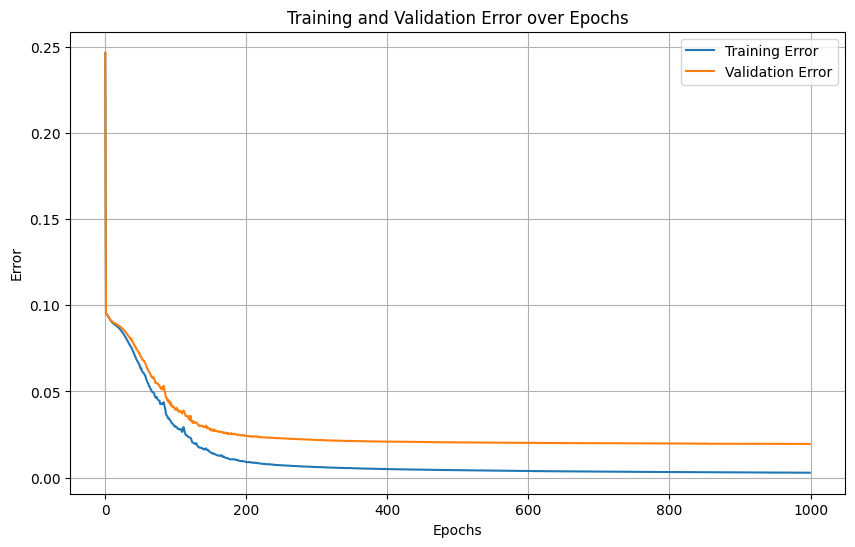

In [114]:
import matplotlib.pyplot as plt

# Plotting the training and validation errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Training Error')
plt.plot(val_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [115]:
from sklearn.metrics import confusion_matrix
# Let's see the performance of the trained network

X_h = sigmoid(np.dot(W_h, X_test) + b_h)  # hidden layer
y_o = sigmoid(np.dot(W_o, X_h) + b_o)  # output layer
error = error_function(T_test, y_o)

print("Error:", error)

# Now using sklearn metrics

y_pred = np.argmax(y_o, axis=0)
y_true = np.argmax(T_test, axis=0)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1 score:", f1_score(y_true, y_pred, average="macro"))




Error: 0.019584528980490425
Accuracy: 0.865
Precision: 0.8673585858585859
Recall: 0.8669930295147686
F1 score: 0.8611661893914107


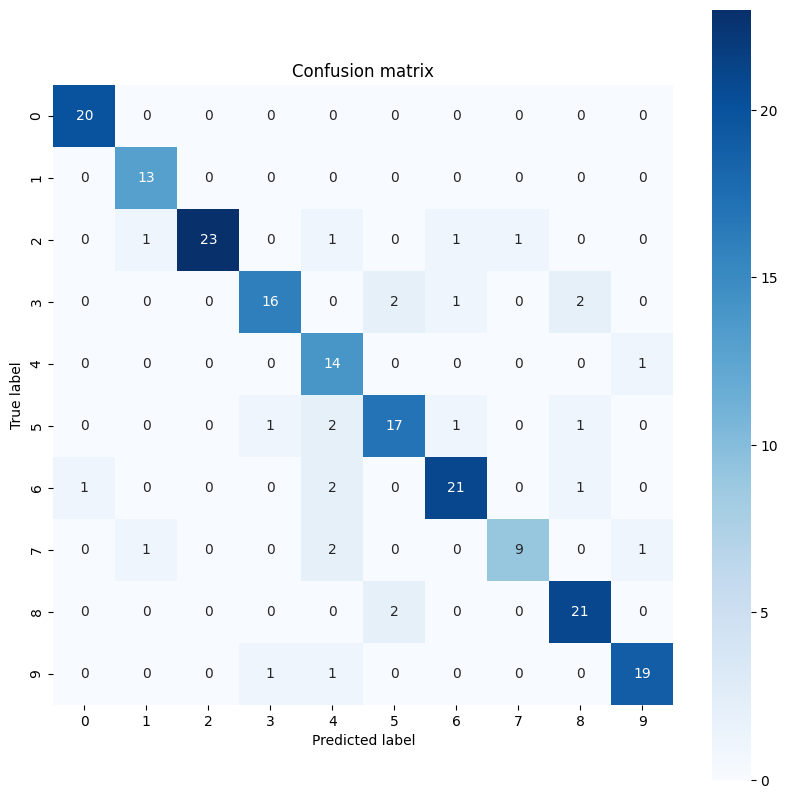

In [116]:
# Let's see the confusion matrix in full color

import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', square=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()